## Generate plots from H(x) IODA files of AERONET Level 1.5 data
This notebook can generate density distribution (if `pltstats` is True) and the corresponding site map with avaiable data counts.

In [1]:
import os
from tqdm import tqdm
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mpcrs
from custom_colormaps import white_gist_earth
from functions import set_size, setupax_2dmap, setup_cmap, get_dates
from joblib import Parallel, delayed

### Setup the running period, features of figure, and processing observations

In [2]:
sdate = 2024110100
edate = 2024113018
date_interval = 6
dates = get_dates(sdate, edate, date_interval)
bkg = 'MERRA-2'
plot_wvl = 500
plotvar = 'aerosolOpticalDepth'
pltstats = True
show_stats = True
quality = 600
# Plotting setup
txsize = 14
mpl.rc('axes', titlesize=txsize, labelsize=txsize)
mpl.rc('xtick', labelsize=txsize)
mpl.rc('ytick', labelsize=txsize)
mpl.rc('legend', fontsize='large')
proj = ccrs.PlateCarree()

In [3]:
# Control hist2d
hist2d_in_log = 1
hist2d_xmax = 5.0
hist2d_xybins = 30
if hist2d_in_log:
    h2d_axis = np.linspace(np.log(0.01), np.log(hist2d_xmax), hist2d_xybins+1)
    h2d_axis = np.exp(h2d_axis)
else:
    h2d_axis = np.linspace(0.01, hist2d_xmax, hist2d_xybins+1)

In [4]:
hofx_path = '/glade/work/swei/Git/JEDI-METplus/output/aodobs_merra2/hofx/f00'
obs_name = 'aeronet_l15_aod'

aeronet_aod_wvl = [340., 380., 440., 500., 675, 870., 1020., 1640.]

data_name_dict = {
    'pace_aod': 'OCI UAA AOD on PACE',
    'modis_aqua_aod': 'MODIS AOD on Aqua',
    'modis_terra_aod': 'MODIS AOD on Terra',
    'viirs_aod_dt_n20': 'VIIRS DT AOD on NOAA-20',
    'viirs_aod_db_n20': 'VIIRS DB AOD on NOAA-20',
    'viirs_aod_dt_npp': 'VIIRS DT AOD on Suomi-NPP',
    'viirs_aod_db_npp': 'VIIRS DB AOD on Suomi-NPP',
    'aeronet_l15_aod': 'AERONET Level 1.5 AOD',
}
shortvar_dict = {
    'aerosolOpticalDepth': 'AOD'
}

In [5]:
savedir = '/glade/work/swei/projects/mmm.pace_aod/plots'
cycs_savedir = f'{savedir}/cycles'
stat_savedir = f'{savedir}/stats/'
if not os.path.exists(stat_savedir):
    os.makedirs(stat_savedir)

### Define local functions

In [6]:
def plt_hist2d(dataframe, x, y, axis, show_stats, savename, **kwargs):
    x_data = dataframe[x]
    y_data = dataframe[y]
    xlbstr = kwargs.get('xlb', x)
    ylbstr = kwargs.get('ylb', y)
    hist2d, x_edge, y_edge = np.histogram2d(x_data,
                                            y_data,
                                            bins=axis)

    cnlvs = np.linspace(0, hist2d.max(), 256)
    clrnorm = mpcrs.BoundaryNorm(cnlvs, len(cnlvs), extend='max')

    fig, ax = plt.subplots()
    set_size(5, 5, b=0.1, l=0.1, r=0.95, t=0.95)
    cn = ax.contourf(axis[:-1], axis[:-1], hist2d.swapaxes(0,1),
                     levels=cnlvs, norm=clrnorm, cmap=white_gist_earth,
                     extend='max',)
    plt.plot(
        [0.0, hist2d_xmax],
        [0.0, hist2d_xmax],
        color='gray',
        linewidth=2,
        linestyle='--'
    )
    plt.xlim(0.01, hist2d_xmax)
    plt.ylim(0.01, hist2d_xmax)

    if hist2d_in_log:
        ax.set_xscale('log')
        ax.set_yscale('log')
    ax.set_aspect('equal')

    plt.grid(alpha=0.5)
    plt.xlabel(xlbstr)
    plt.ylabel(ylbstr)

    # Calculate statistics and place it on the top-left corner
    if show_stats:
        correlation_matrix = np.corrcoef(x_data, y_data)
        correlation_xy = correlation_matrix[0, 1]
        r_squared = correlation_xy ** 2
        bias = np.mean(y_data) - np.mean(x_data)
        rbias = bias/np.mean(x_data)
        ssize = len(x_data)
        rmse = np.sqrt(np.mean((y_data - x_data) ** 2))
        stats_dict = {
            'Counts': str("%.0f" % ssize),
            'Absolute Bias': str("%.3f" % bias),
            'Relative Bias': str("%.3f" % rbias),
            'RMSE': str("%.3f" % rmse),
            # 'R': str("%.3f" % correlation_xy),
            'R\u00b2': str("%.3f" % r_squared),
        }
        x_pos = 0.012
        y_pos = 1.02
        for key in stats_dict.keys():
            stat_str = '%s= %s' %(key, stats_dict[key])
            y_pos = y_pos - 0.05
            ax.annotate(stat_str, (x_pos, y_pos), ha='left', va='center', 
                        fontsize=12, xycoords='axes fraction')

    cb = plt.colorbar(cn, orientation='horizontal', fraction=0.03, aspect=30, 
                      pad=0.12, extend='max', ticks=cnlvs[::50])
    cb.ax.minorticks_off()
    cb.ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0),
                           useMathText=True)
    plt.savefig(savename, dpi=quality)

    return

In [7]:
def process_dates(cdate, obsname):
    cdate_str = cdate.strftime('%Y%m%d%H')
    hofxfile = f'{hofx_path}/{obsname}/hofx.{obsname}.{cdate_str}.nc4'
    metads = xr.open_dataset(hofxfile, group='MetaData')
    ch_wvl = aeronet_aod_wvl

    obsvds = xr.open_dataset(hofxfile, group='ObsValue').assign_coords(Channel=ch_wvl)
    hofxds = xr.open_dataset(hofxfile, group='hofx').assign_coords(Channel=ch_wvl)

    tmpdf = pd.DataFrame()
    tmpdf['lat'] = metads['latitude']
    tmpdf['lon'] = metads['longitude']
    tmpdf['station'] = metads['stationIdentification']
    tmpdf['obs'] = obsvds['aerosolOpticalDepth'].sel(Channel=plot_wvl)
    tmpdf['hfx'] = hofxds['aerosolOpticalDepth'].sel(Channel=plot_wvl)
    tmpdf['omb'] = tmpdf['obs'] - tmpdf['hfx']

    return tmpdf

### Loop through the whole period 
It creates the Dataframe for density distribution plot

Processing aeronet_l15_aod


100%|██████████| 120/120 [00:02<00:00, 41.07it/s]


/glade/work/swei/projects/mmm.pace_aod/plots/stats//all.hist2d.aeronet_l15_aod.500nm.2024110100_2024113018.png
Process Finished


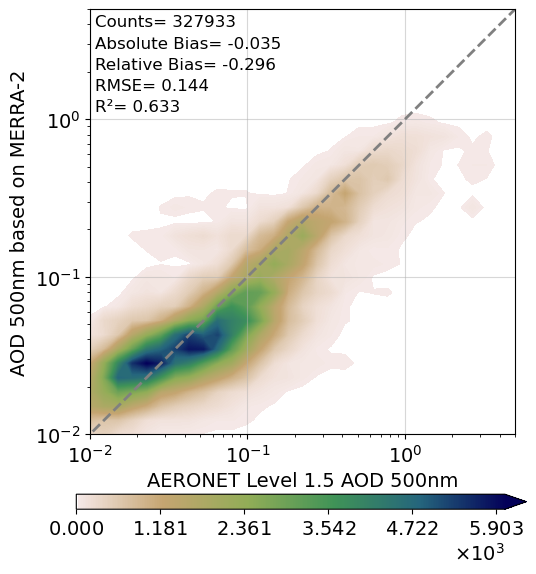

In [8]:
out_dict = {}
print(f'Processing {obs_name}')
results = Parallel(n_jobs=-1)(delayed(process_dates)(cdate, obs_name) for cdate in tqdm(dates))
alldf = pd.concat(results, ignore_index=True)
mask = ~alldf['obs'].isnull()

if pltstats:
    pltdf = alldf.loc[mask].reset_index(drop=True)
    # pltdf['obs_bin'] = pd.cut(pltdf['obs'], bins=bins, labels=bin_lb, right=True)

    hist2dplt = f'{stat_savedir}/all.hist2d.{obs_name}.{plot_wvl}nm.{sdate}_{edate}.png'
    plt_hist2d(pltdf, 'obs', 'hfx', h2d_axis, show_stats, hist2dplt,
               xlb=f'{data_name_dict[obs_name]} {plot_wvl}nm',
               ylb=f'{shortvar_dict[plotvar]} {plot_wvl}nm based on {bkg}')
    print(hist2dplt)

print('Process Finished')

### Create site map of AERONET L1.5 H(x) 
Based on the plotting DataFrame, counts the available data and plot the site map with varying dot size

In [9]:
counts = pltdf['station'].value_counts().reset_index()
counts.columns = ['station', 'count']
latlon = pltdf.drop_duplicates(subset='station')[['station', 'lat', 'lon']]
station_count_df = pd.merge(counts, latlon, on='station')

station_count_df['size'] = station_count_df['count'] / max(station_count_df['count'].values) * quality
cnt2size_ratio = max(station_count_df['count'].values) / quality
legend_sizes = [50, 200, 400]  # sizes you want to show in legend
legend_cnts = [round(size * cnt2size_ratio) for size in legend_sizes]
station_count_df

,station,count,lat,lon,size
0,University_of_Nizwa,3074,22.910101,57.674099,600.000000
1,IITM_ARTCI_Bhopal,2939,23.572260,77.244293,573.649967
2,Tamanrasset_INM,2681,22.790001,5.530000,523.292128
3,CUT-TEPAK,2668,34.674805,33.042751,520.754717
4,Jaipur,2385,26.905817,75.806213,465.517241
...,...,...,...,...,...
430,Ji_Parana_UNIR,4,-10.882212,-61.968601,0.780742
431,Dunkerque,4,51.035351,2.368117,0.780742
432,KITcube_Masada,2,31.322548,35.372295,0.390371
433,DRAGON_NREL-Golden,1,39.743725,-105.177994,0.195185


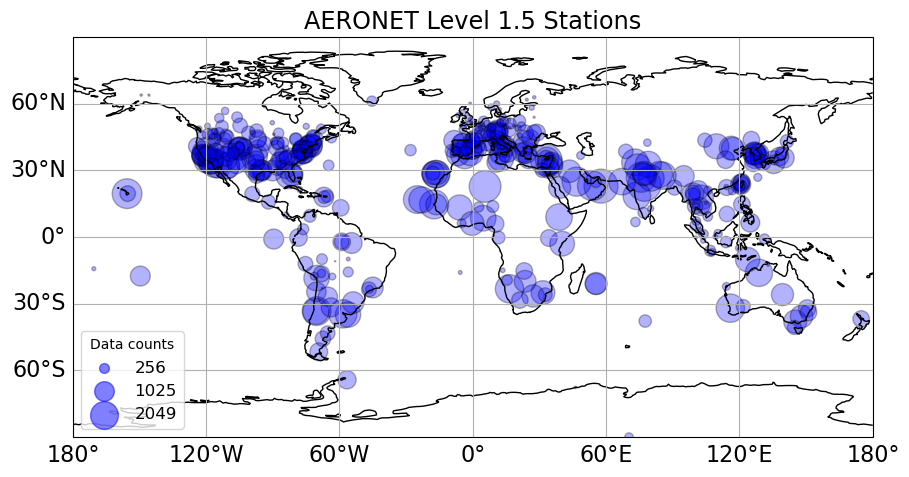

In [10]:
area_corner = [-180., 180., -90., 90.]

fig, ax, gl = setupax_2dmap(area_corner, proj, lbsize=txsize+2)
set_size(8, 5, l=0.08, r=0.96, t=1.02, b=-0.02)

# Scatter
sc = ax.scatter(
    station_count_df['lon'], station_count_df['lat'],
    s=station_count_df['size'],  # scale size
    color='blue', alpha=0.3, edgecolor='black', transform=ccrs.PlateCarree()
)

handles = [plt.scatter([], [], s=size, color='blue', alpha=0.5, label=f'{cnts}')
           for size, cnts in zip(legend_sizes, legend_cnts)]
plt.legend(handles=handles, title='Data counts', loc=3)
plt.title('AERONET Level 1.5 Stations', size='xx-large')
stationplt = f'{stat_savedir}/AERONETL15.{sdate}_{edate}.png'
fig.savefig(stationplt, dpi=quality)